In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import rustworkx
import rustworkx.visualization
import json

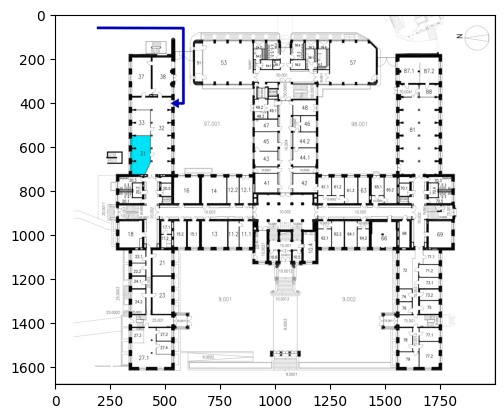

In [2]:
img = cv2.imread('../data/cab_floor_0.png')
plt.imshow(img)

In [3]:
scale = np.array([img.shape[1], img.shape[0]])

In [5]:
pointcloud_img = cv2.imread("../data/plan_vote.png")
(height,width,_) = pointcloud_img.shape
floor_plan = cv2.resize(img, (width, height))

In [6]:
colors = []
count = 0

def select(image, k=4):
    global count
    
    selected_points = []
    
    def mouse_click(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            # Add clicked point to the list
            selected_points.append((x, y))
            # Display the selected point on the image
            
            if len(selected_points) < len(colors):
                color = colors[len(selected_points)]
            else:
                color = np.random.uniform(255, size=3)
                colors.append(color)
            cv2.circle(image, (x, y), 10, color, -1)
            cv2.imshow(window_name, image)
    
    window_name = 'image_' + str(count)
    cv2.namedWindow(window_name)
    image = np.copy(image)

    # Display the image
    cv2.imshow(window_name, image)

    # Set mouse click event callback
    cv2.setMouseCallback(window_name, mouse_click)

    # Wait for the user to click points and press 'q' to quit
    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

    # Print selected points
    print("Selected Points:")
    for point in selected_points:
        print(point)
        
    count += 1
    return selected_points

point_cloud_points = select(pointcloud_img)
floor_plan_points = select(floor_plan)

cv2.destroyAllWindows()

Selected Points:
(412, 394)
(527, 441)
(532, 426)
(604, 457)
(597, 467)
(712, 511)
(694, 554)
(581, 509)
(548, 575)
(562, 581)
(537, 644)
(523, 637)
(491, 706)
(603, 752)
Selected Points:
(901, 112)
(898, 449)
(929, 447)
(929, 654)
(898, 652)
(902, 987)
(793, 986)
(795, 658)
(611, 650)
(612, 693)
(461, 693)
(461, 651)
(278, 650)
(278, 988)
(171, 986)


In [11]:
(len(floor_plan_points), len(point_cloud_points))

(14, 14)

In [7]:
np.array([0,1,2,3,4,5]).reshape((2,3))

array([[0, 1, 2],
       [3, 4, 5]])

In [38]:
def compute_linear_transformation(source_points, destination_points):
    A = np.zeros((2 * len(source_points), 6))
    b = np.zeros(2 * len(source_points))
    
    for i in range(len(source_points)):
        x_s, y_s = source_points[i]
        x_d, y_d = destination_points[i]
        A[2*i] = [x_s,y_s,1,0,0,0]
        A[2*i+1] = [0,0,0,x_s,y_s,1]
        b[2*i] = x_d
        b[2*i+1] = y_d

    # Solving the linear system using SVD
    transformation_matrix = np.linalg.lstsq(A,b)[0]
    transformation_matrix = np.concatenate([transformation_matrix,[0,0,1]]).reshape((3,3))
    return transformation_matrix

In [46]:
print((height,width))

floor_to_rel = compute_linear_transformation(np.array(floor_plan_points) / [width,height],
                              np.array(point_cloud_points) / [width,height])


aabb_min = np.array([-80.19033051, -160.14266968, -14.49797497])
aabb_max = np.array([173.27059428, 107.40621185, 46.93898773])

rel_to_abs = np.array([
    [aabb_max[0]-aabb_min[0], 0,                        aabb_min[0]],
    [0                      ,  aabb_min[1]-aabb_max[1], aabb_max[1]], # y-flipped, since in image up is 0
    [0,0,1]
])

print("floor_to_relative = ", floor_to_rel)
print("relative_to_absolute =", rel_to_abs)

(1024, 1024)
floor_to_relative =  [[ 0.17137878  0.34187206  0.21509406]
 [-0.38568048  0.1352338   0.70865127]
 [ 0.          0.          1.        ]]
relative_to_absolute = [[ 253.46092479    0.          -80.19033051]
 [   0.         -267.54888153  107.40621185]
 [   0.            0.            1.        ]]


/var/folders/3d/9nhm2px925gfpntwdmfgxjkc0000gn/T/ipykernel_1684/4277589055.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  transformation_matrix = np.linalg.lstsq(A,b)[0]


In [53]:
# Rustworkx's undirected graph type.
graph = rustworkx.PyGraph()

def apply_trans(matrix, pos):
    pos = np.array(pos)
    return (matrix @ [pos[0],pos[1],1])[:2]

rel_to_world = lambda x: apply_trans(rel_to_abs @ floor_to_rel, x)
world_to_rel = lambda x: apply_trans(np.linalg.inv(rel_to_abs @ floor_to_rel), x)

# Each time add node is called, it returns a new node index
a = graph.add_node({"label": "A", "pos": rel_to_world([0.5,0.3])})
b = graph.add_node({"label": "B", "pos": rel_to_world([0.5,0.5])})
c = graph.add_node({"label": "C", "pos": rel_to_world([0.15,0.5])})
d = graph.add_node({"label": "D", "pos": rel_to_world([0.85,0.5])})

# add_edges_from takes tuples of node indices and weights,
# and returns edge indices
graph.add_edges_from([(a, b, {"length": np.linalg.norm(graph[a]["pos"] - graph[b]["pos"])}), 
                      (b, c, {"length": np.linalg.norm(graph[b]["pos"] - graph[c]["pos"])}),
                       (b, d, {"length": np.linalg.norm(graph[b]["pos"] - graph[d]["pos"])})])

paths = rustworkx.all_pairs_dijkstra_shortest_paths(graph, edge_cost_fn= lambda x: x["length"])
list(paths[c][d])

[2, 1, 3]

In [43]:
rel_to_abs @ [1,1,1]

array([173.27059428,  27.45387268,   1.        ])

/var/folders/3d/9nhm2px925gfpntwdmfgxjkc0000gn/T/ipykernel_1684/3500547437.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  transformation_matrix = np.linalg.lstsq(A,b)[0]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


uint8
(2, 3)
[[ 8.72145420e-01 -2.20478366e+00  1.40795757e+03]
 [ 2.48734181e+00  1.10524999e+00 -1.34977090e+03]]


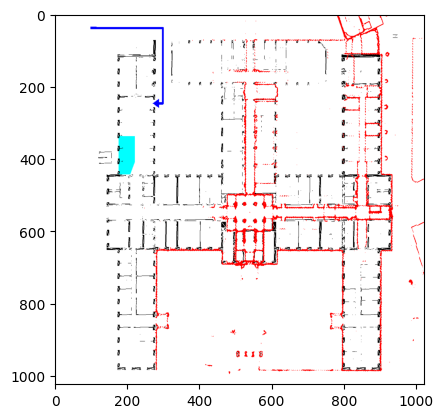

In [17]:
warp_matrix = compute_linear_transformation(np.array(point_cloud_points), np.array(floor_plan_points))
print(floor_plan.dtype)
#floor_plan = floor_plan.astype(np.float32)
print(warp_matrix.shape)
print(warp_matrix)
pointcloud_img_warped = cv2.warpAffine(pointcloud_img, warp_matrix, (floor_plan.shape[1], floor_plan.shape[0]))

_,mask = cv2.threshold(pointcloud_img_warped, 100, 255, cv2.THRESH_BINARY_INV)

red = np.zeros((height,width,3))
red[:,:,0] = 255 

composite = np.choose(mask==255, [floor_plan, red])
plt.imshow(composite)

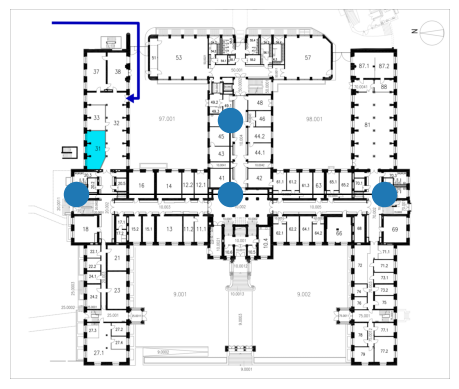

In [54]:
plt.imshow(img)
rustworkx.visualization.mpl_draw(graph, pos={i: world_to_rel(data["pos"])*scale for i,data in enumerate(graph.nodes())})

In [55]:
def graph_to_json(graph):
    nodes = {}
    for node, data in enumerate(graph.nodes()):
        nodes[node] = {
            "label": data["label"],
            "pos": {"x": data["pos"][0], "y": data["pos"][1]}
        }
    edges = {}
    for edge, data in enumerate(graph.edges()):
        u,v = graph.get_edge_endpoints_by_index(edge)
        edges[edge] = {
            "u": u,
            "v": v, 
            "data": {"length": data["length"]}
        }

        
    print(list(graph.edge_indices()))
    return json.dumps({"nodes": nodes, "edges": edges})
    
j = graph_to_json(graph)
j

[0, 1, 2]


'{"nodes": {"0": {"label": "A", "pos": {"x": 22.041882992784863, "y": -41.45294826785856}}, "1": {"label": "B", "pos": {"x": 39.37212469636901, "y": -48.6892788106351}}, "2": {"label": "C", "pos": {"x": 24.16888647340641, "y": -84.80521252269463}}, "3": {"label": "D", "pos": {"x": 54.57536291933161, "y": -12.573345098575572}}}, "edges": {"0": {"u": 0, "v": 1, "data": {"length": 18.780355620407402}}, "1": {"u": 1, "v": 2, "data": {"length": 39.185445261704366}}, "2": {"u": 1, "v": 3, "data": {"length": 39.185445261704366}}}}'

In [ ]:
def graph_from_json(json):
    idx_to_node = {}
    graph = rustworkx.PyGraph()
    for id,data in sorted(json["nodes"].items(), key=lambda x: x[0]):
        idx_to_node[int(id)] = graph.add_node({
            "label": data["label"],
            "pos": np.array([data["pos"]["x"], data["pos"]["y"]])
        })
        
    print(idx_to_node)
        
    for id,data in sorted(json["edges"].items(), key=lambda x: x[0]):
        graph.add_edge(idx_to_node[data["u"]],idx_to_node[data["v"]],{"length": data["length"]})
    
    return graph

graph2 = graph_from_json(json.loads(j))
plt.imshow(img)
rustworkx.visualization.mpl_draw(graph2, pos={i: data["pos"]*scale for i,data in enumerate(graph.nodes())})

In [ ]:
{
    "_to_floorplan:"
}